In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

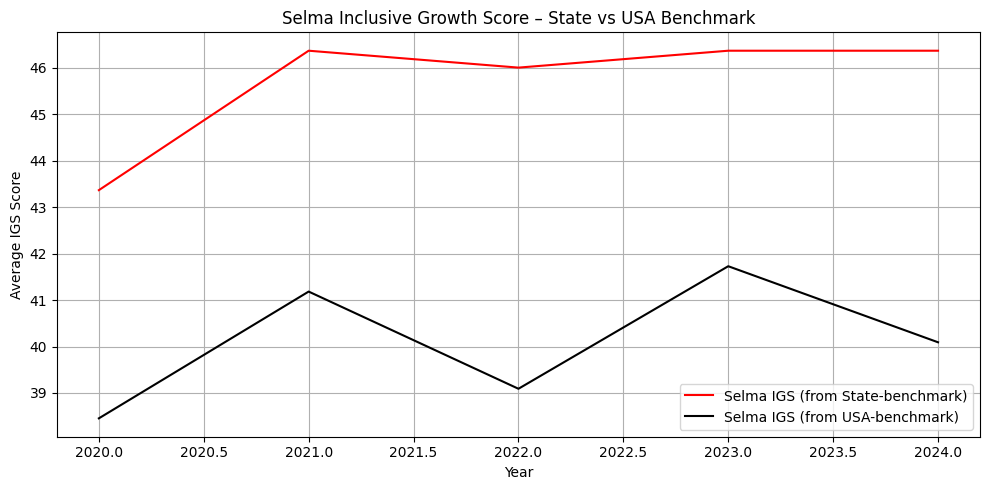

In [11]:

df_usa = pd.read_csv("Selma/Compared to USA.csv")
plt.figure(figsize=(10,5))

plt.plot(avg_state.index, avg_state.values,
         label="Selma IGS (from State-benchmark)",
         color="red")
plt.plot(avg_usa.index, avg_usa.values,
         label="Selma IGS (from USA-benchmark)",
         color="black")

plt.xlabel("Year")
plt.ylabel("Average IGS Score")
plt.title("Selma Inclusive Growth Score – State vs USA Benchmark")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


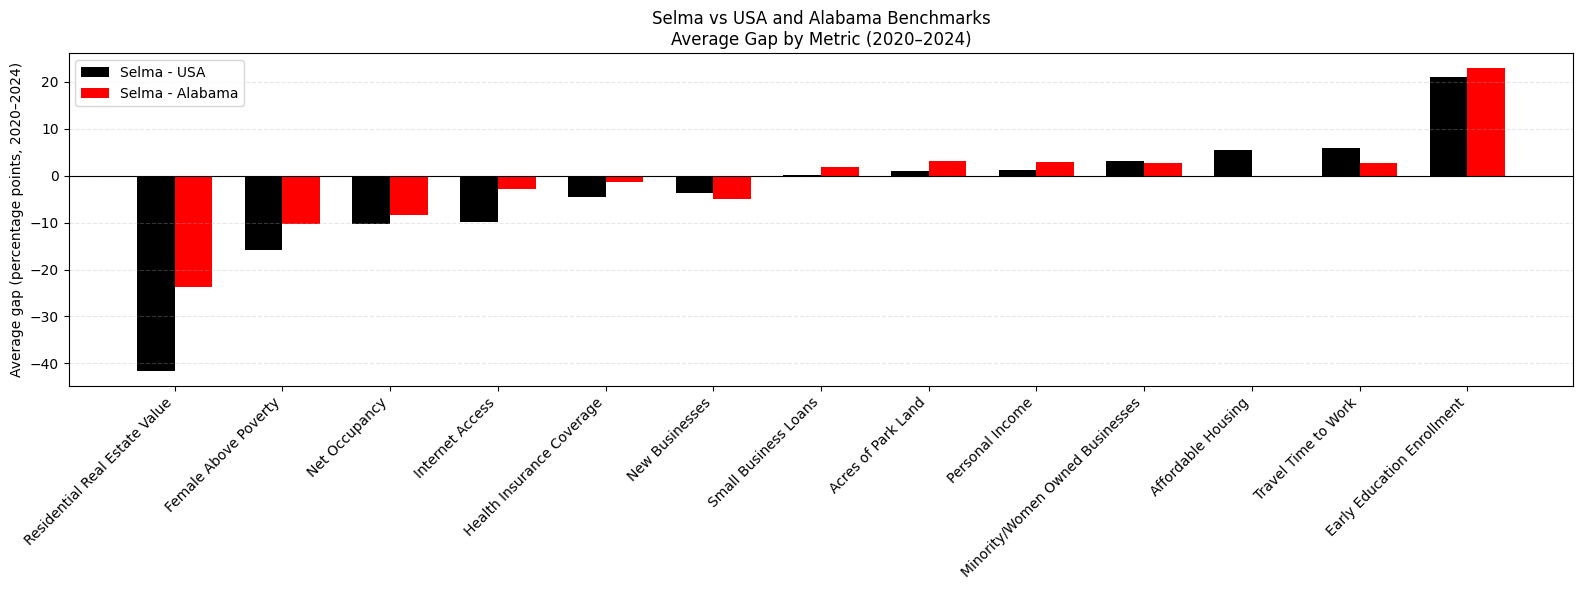

In [19]:


# Load & clean the IGS CSVs

def load_igs_csv(path):
    raw = pd.read_csv(path)

    # First row has the real column names
    header = raw.iloc[0]
    new_cols = {
        col: (header[col] if isinstance(header[col], str) else col)
        for col in raw.columns
    }
    df = raw.rename(columns=new_cols)

    # Drop the first two rows (header row + blank row)
    df = df.iloc[2:].reset_index(drop=True)

    # Make Year numeric so we can filter 2020–2024
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")

    return df

usa_df = load_igs_csv("Selma/Compared to USA.csv")
state_df = load_igs_csv("Selma/Compared to State.csv") 

#Choose the metrics and compute average gaps 

metrics = [
    "Residential Real Estate Value",
    "Female Above Poverty",
    "Net Occupancy",
    "Internet Access",
    "Health Insurance Coverage",
    "New Businesses",
    "Small Business Loans",
    "Acres of Park Land",
    "Personal Income",
    "Minority/Women Owned Businesses",
    "Affordable Housing",
    "Travel Time to Work",
    "Early Education Enrollment",
]

def average_gaps(df, metrics, year_start=2020, year_end=2024):
    sub = df[df["Year"].between(year_start, year_end)].copy()

    gaps = {}
    for m in metrics:
        base_col = f"{m} Base, %"
        tract_col = f"{m} Tract, %"

        base = pd.to_numeric(sub[base_col], errors="coerce")
        tract = pd.to_numeric(sub[tract_col], errors="coerce")

        # Selma – benchmark
        gaps[m] = (tract - base).mean()

    return gaps

gaps_usa = average_gaps(usa_df, metrics)
gaps_state = average_gaps(state_df, metrics)

usa_vals = [gaps_usa[m] for m in metrics]
state_vals = [gaps_state[m] for m in metrics]

# Plotted chart

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(16, 6))

plt.bar(x - width/2, usa_vals, width,
        label="Selma - USA", color="black")
plt.bar(x + width/2, state_vals, width,
        label="Selma - Alabama", color="red")

plt.axhline(0, color="black", linewidth=0.8)

plt.xticks(x, metrics, rotation=45, ha="right")
plt.ylabel("Average gap (percentage points, 2020–2024)")
plt.title("Selma vs USA and Alabama Benchmarks\nAverage Gap by Metric (2020–2024)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()

plt.show()


Correlations with Inclusive Growth Score (Selma, tract-level only):
Inclusion                                   0.775575
Economy                                     0.750063
Economy Inclusion                           0.673075
Labor Market Engagement Index Tract         0.546608
Internet Access Tract, %                    0.544756
Community                                   0.500441
Community Inclusion                         0.479704
Health Insurance Coverage Tract, %          0.470101
Female Above Poverty Tract, %               0.428247
Minority/Women Owned Businesses Tract, %    0.356952
Place Inclusion                             0.317007
Early Education Enrollment Tract, %         0.257776
Gini Coefficient Tract                     -0.218310
Growth                                      0.192232
New Businesses Tract, %                     0.180966
Residential Real Estate Value Tract, %     -0.174883
Personal Income Tract, %                   -0.159018
Travel Time to Work Tract, %   

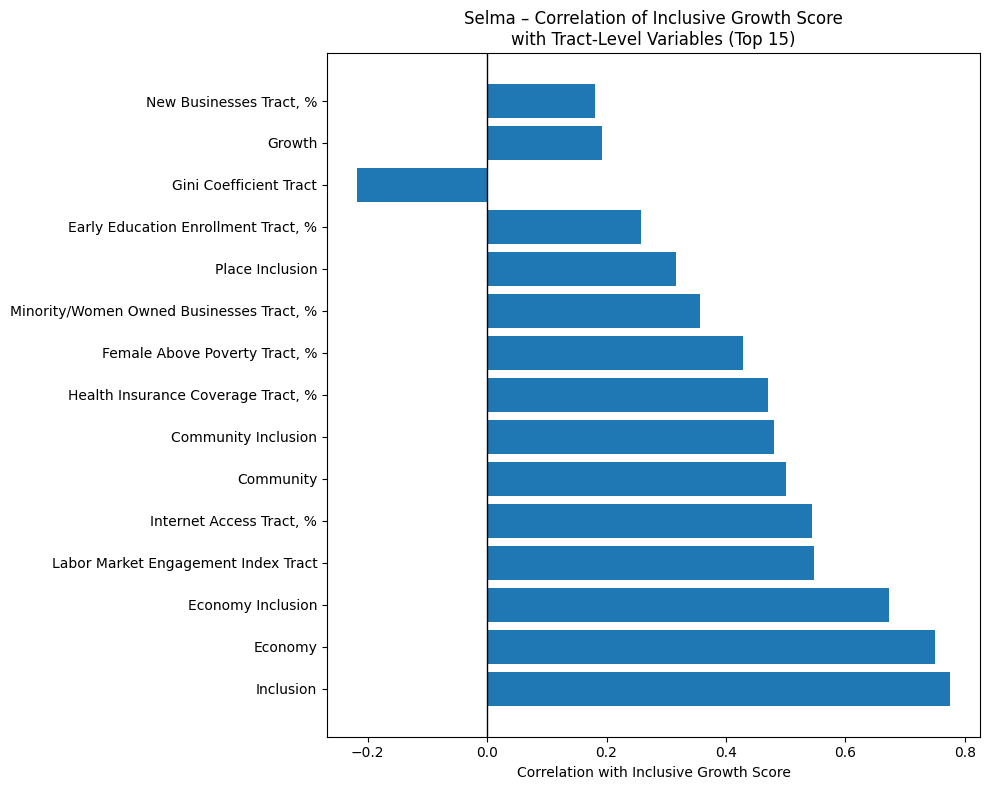

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load Selma CSV
def load_igs_csv(path):
    raw = pd.read_csv(path, header=None)
    header = raw.iloc[1]
    df = raw.rename(columns=header).iloc[3:].reset_index(drop=True)
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
    return df

selma_df = load_igs_csv("Selma/Compared to USA.csv")

# 2. Start from a copy
df_num = selma_df.copy()

# Drop obviously non-numeric ID/text columns
non_numeric_like = [
    "Census Tract FIPS code",
    "County",
    "State",
    "Place",
    "Is an Opportunity Zone",
]

for c in non_numeric_like:
    if c in df_num.columns:
        df_num = df_num.drop(columns=c)

# Drop any column whose header is NaN / not a string
cols_bad_name = [c for c in df_num.columns
                 if not isinstance(c, str) or str(c).lower() == "nan"]
df_num = df_num.drop(columns=cols_bad_name, errors="ignore")

# Drop all "Base" columns (we only want tract-level, not national benchmark)
base_cols = [c for c in df_num.columns if "base" in str(c).lower()]
df_num = df_num.drop(columns=base_cols, errors="ignore")

target = "Inclusive Growth Score"

# Drop all *Score* columns EXCEPT the target itself
score_cols = [c for c in df_num.columns
              if "score" in str(c).lower() and c != target]
df_num = df_num.drop(columns=score_cols, errors="ignore")

# Convert remaining columns to numeric where possible
for col in df_num.columns:
    df_num[col] = pd.to_numeric(df_num[col], errors="coerce")

# Keep only numeric columns
df_num = df_num.select_dtypes(include=["number"])

# 3. Correlation with Inclusive Growth Score (tract-level predictors only)
if target not in df_num.columns:
    print("Column not found:", target)
    print("Available numeric columns are:")
    print(df_num.columns.tolist())
else:
    corr = df_num.corr()
    corr_with_igs = corr[target].dropna()

    # Optionally drop Year as a predictor if you don't want time in the list
    corr_with_igs = corr_with_igs.drop(labels=[target, "Year"], errors="ignore")

    # Sort by absolute correlation strength
    corr_sorted = corr_with_igs.reindex(
        corr_with_igs.abs().sort_values(ascending=False).index
    )

    print("Correlations with Inclusive Growth Score (Selma, tract-level only):")
    print(corr_sorted)

    # Save for inspection
    corr_sorted.to_csv(
        "selma_corr_with_inclusive_growth_score_tract_only_top_vars.csv",
        header=["corr"]
    )

    # 4. Plot top 15 variables
    TOP_N = 15
    top_corr = corr_sorted.head(TOP_N)

    plt.figure(figsize=(10, 0.4 * TOP_N + 2))
    y_pos = np.arange(len(top_corr))

    plt.barh(y_pos, top_corr.values)
    plt.yticks(y_pos, top_corr.index)
    plt.axvline(0, color="black", linewidth=1)

    plt.title("Selma – Correlation of Inclusive Growth Score\nwith Tract-Level Variables (Top 15)")
    plt.xlabel("Correlation with Inclusive Growth Score")
    plt.tight_layout()
    plt.show()


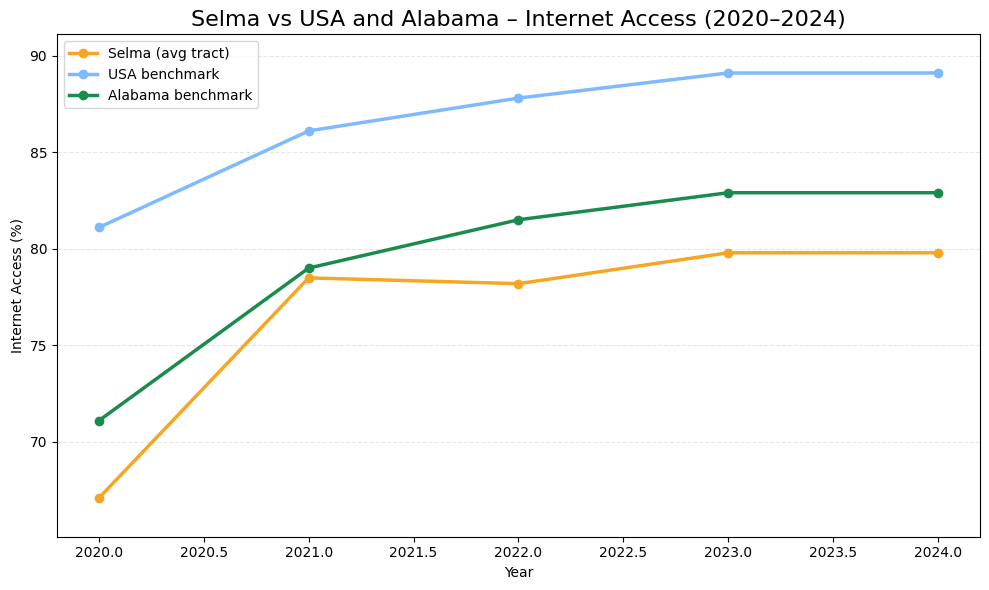

In [20]:


# ---------- 1. Load & clean the CSVs (same logic as before) ----------

def load_igs_csv(path):
    raw = pd.read_csv(path)

    # First row has the real column names
    header = raw.iloc[0]
    new_cols = {
        col: (header[col] if isinstance(header[col], str) else col)
        for col in raw.columns
    }
    df = raw.rename(columns=new_cols)

    # Drop header/blank rows
    df = df.iloc[2:].reset_index(drop=True)

    # Make Year numeric
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")

    return df

usa_df   = load_igs_csv("Selma/Compared to USA.csv")
state_df = load_igs_csv("Selma/Compared to State.csv")   # Alabama benchmark

# ---------- 2. Pick the metric you want to zoom in on ----------

metric = "Internet Access"

tract_col = f"{metric} Tract, %"
base_col  = f"{metric} Base, %"

# We'll use the USA file for Selma (tract) because tract = Selma in both files
selma = usa_df[["Year", tract_col]].copy()
selma[tract_col] = pd.to_numeric(selma[tract_col], errors="coerce")

usa = usa_df[["Year", base_col]].copy()
usa[base_col] = pd.to_numeric(usa[base_col], errors="coerce")

alabama = state_df[["Year", base_col]].copy()
alabama[base_col] = pd.to_numeric(alabama[base_col], errors="coerce")

# ---------- 3. Get averages by year (2020–2024 only) ----------

year_min, year_max = 2020, 2024

selma_by_year   = selma.groupby("Year")[tract_col].mean().loc[year_min:year_max]
usa_by_year     = usa.groupby("Year")[base_col].mean().loc[year_min:year_max]
alabama_by_year = alabama.groupby("Year")[base_col].mean().loc[year_min:year_max]

years = selma_by_year.index.values

# ---------- 4. Plot the line chart ----------

plt.figure(figsize=(10, 6))

plt.plot(years, selma_by_year.values,
         marker="o", linewidth=2.5,
         label="Selma (avg tract)", color="#f5a623")

plt.plot(years, usa_by_year.values,
         marker="o", linewidth=2.5,
         label="USA benchmark", color="#7fb9ff") 

plt.plot(years, alabama_by_year.values,
         marker="o", linewidth=2.5,
         label="Alabama benchmark", color="#1b8b4d") 

plt.title("Selma vs USA and Alabama – Internet Access (2020–2024)", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Internet Access (%)")
plt.ylim(min(selma_by_year.min(), usa_by_year.min(), alabama_by_year.min()) - 2,
         max(selma_by_year.max(), usa_by_year.max(), alabama_by_year.max()) + 2)

plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


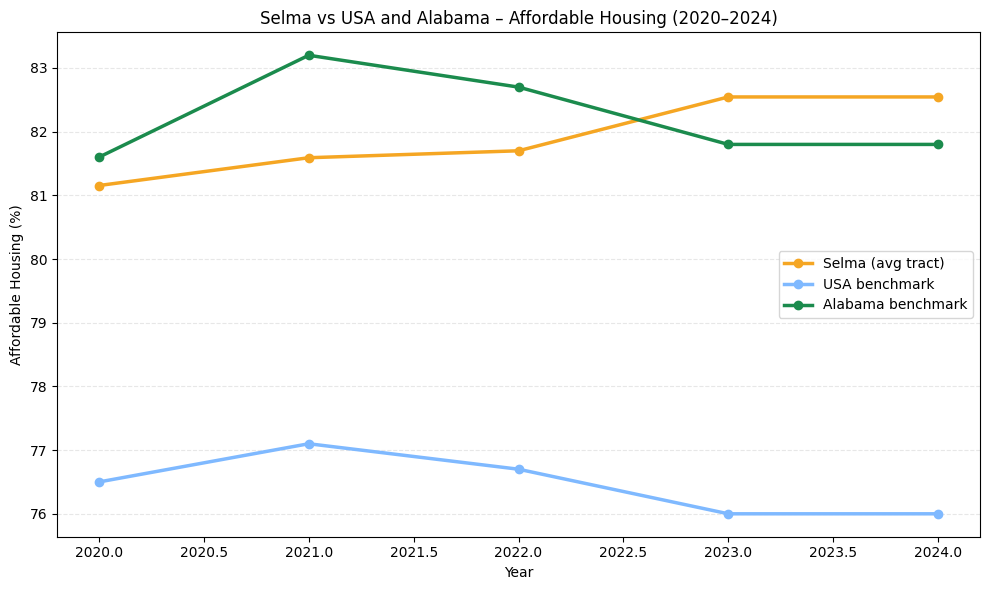

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 1. Load & clean CSVs once ----------

def load_igs_csv(path):
    raw = pd.read_csv(path)
    header = raw.iloc[0]
    new_cols = {
        col: (header[col] if isinstance(header[col], str) else col)
        for col in raw.columns
    }
    df = raw.rename(columns=new_cols)
    df = df.iloc[2:].reset_index(drop=True)
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
    return df

usa_df   = load_igs_csv("Selma/Compared to USA.csv")
state_df = load_igs_csv("Selma/Compared to State.csv")   # Alabama

# ---------- 2. Function to plot ACTUAL values ----------

def plot_metric_levels(metric, year_min=2020, year_max=2024):
    tract_col = f"{metric} Tract, %"
    base_col  = f"{metric} Base, %"

    # Selma + USA from USA file
    selma = usa_df[["Year", tract_col]].copy()
    usa_b = usa_df[["Year", base_col]].copy()

    # Alabama from State file
    alabama = state_df[["Year", base_col]].copy()

    for df, col in [(selma, tract_col), (usa_b, base_col), (alabama, base_col)]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    selma_by_year   = selma.groupby("Year")[tract_col].mean().loc[year_min:year_max]
    usa_by_year     = usa_b.groupby("Year")[base_col].mean().loc[year_min:year_max]
    alabama_by_year = alabama.groupby("Year")[base_col].mean().loc[year_min:year_max]

    years = selma_by_year.index.values

    plt.figure(figsize=(10, 6))

    plt.plot(
        years, selma_by_year.values,
        marker="o", linewidth=2.5,
        label="Selma (avg tract)", color="#f5a623"
    )
    plt.plot(
        years, usa_by_year.values,
        marker="o", linewidth=2.5,
        label="USA benchmark", color="#7fb9ff"
    )
    plt.plot(
        years, alabama_by_year.values,
        marker="o", linewidth=2.5,
        label="Alabama benchmark", color="#1b8b4d"
    )

    plt.title(f"Selma vs USA and Alabama – {metric} (2020–2024)")
    plt.xlabel("Year")
    plt.ylabel(f"{metric} (%)")
    plt.grid(axis="y", linestyle="--", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------- 3. Call it for Affordable Housing ----------

plot_metric_levels("Affordable Housing")


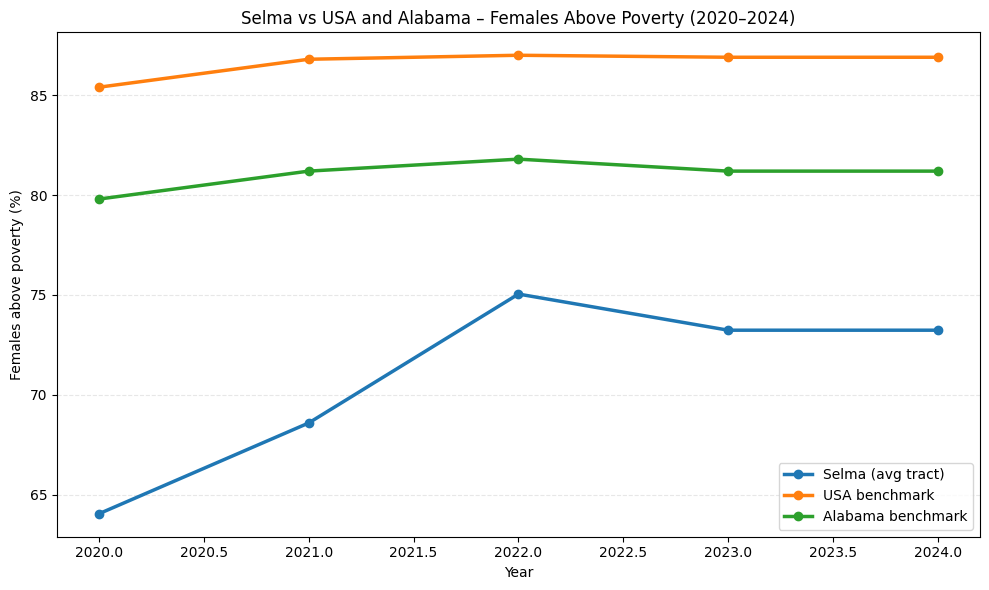

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

def load_igs_csv(path):
    raw = pd.read_csv(path)
    # Use row 0 as the real header
    header = raw.iloc[0]
    new_cols = {col: (header[col] if isinstance(header[col], str) else col)
                for col in raw.columns}
    df = raw.rename(columns=new_cols)
    # Drop the header/blank rows
    df = df.iloc[2:].reset_index(drop=True)
    # Make Year numeric
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
    return df

usa_df   = load_igs_csv("Selma/Compared to USA.csv")
state_df = load_igs_csv("Selma/Compared to State.csv")

metric = "Female Above Poverty"
tract_col = f"{metric} Tract, %"
base_col  = f"{metric} Base, %"

# Convert to numeric
for df in (usa_df, state_df):
    df[tract_col] = pd.to_numeric(df[tract_col], errors="coerce")
    df[base_col]  = pd.to_numeric(df[base_col], errors="coerce")

year_min, year_max = 2020, 2024

selma_by_year = (
    usa_df[usa_df["Year"].between(year_min, year_max)]
    .groupby("Year")[tract_col]
    .mean()
)

usa_by_year = (
    usa_df[usa_df["Year"].between(year_min, year_max)]
    .groupby("Year")[base_col]
    .mean()
)

alabama_by_year = (
    state_df[state_df["Year"].between(year_min, year_max)]
    .groupby("Year")[base_col]
    .mean()
)

years = selma_by_year.index.values

plt.figure(figsize=(10, 6))

plt.plot(years, selma_by_year.values, marker="o", linewidth=2.5,
         label="Selma (avg tract)")
plt.plot(years, usa_by_year.values, marker="o", linewidth=2.5,
         label="USA benchmark")
plt.plot(years, alabama_by_year.values, marker="o", linewidth=2.5,
         label="Alabama benchmark")

plt.title("Selma vs USA and Alabama – Females Above Poverty (2020–2024)")
plt.xlabel("Year")
plt.ylabel("Females above poverty (%)")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
